In [44]:
import numpy as np
import pandas as pd
import torch 
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
words = pd.read_table('names.txt', header = None, names = ['name'])
words

name
0          emma
1        olivia
2           ava
3      isabella
4        sophia
...         ...
32028     zylas
32029     zyran
32030     zyrie
32031     zyron
32032     zzyzx

[32033 rows x 1 columns]

In [14]:
# smallest name
words['name'].apply(lambda x: len(x)).min()

2

In [15]:
# largest name length
words['name'].apply(lambda x: len(x)).max()

15

# BiGram Approach (with starting and ending letters)

In [25]:
# separate into bigrams (with extra for starting and ending letters)
b = {}
for word in words['name']:
    # hallucinate a special start token
    chars = ['<S>'] + list(word) + ['<E>']
    for ch1, ch2 in zip(chars, chars[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [30]:
sorted(b.items(), key = lambda x: x[1], reverse = True)

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

In [159]:
# initialize 28 x 28 matrix (26 letters + start + end) for all possible combinations
a = torch.zeros((27, 27), dtype = torch.int32)

In [160]:
characters = sorted(list(set(''.join(words['name']))))
char2idx = {c: i + 1 for i, c in enumerate(characters)}
char2idx['.'] = 0

In [161]:
characters = sorted(list(set(''.join(words['name']))))
# separate into bigrams (with extra for starting and ending letters)
for word in words['name']:
    # hallucinate a special start token
    chars = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(chars, chars[1:]):
        starting_letter = char2idx[ch1]
        ending_letter = char2idx[ch2]
        a[starting_letter, ending_letter] += 1

In [78]:
# show the heatmap
plt.imshow(a, cmap = 'hot', interpolation = 'nearest')

In [80]:
itos = {i:c for c, i in char2idx.items()}

plt.figure(figsize = (16, 16))
plt.imshow(a, cmap = "Blues")
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha = 'center', va = 'bottom', color = 'gray')
        plt.text(j, i, a[i, j].item(), ha = 'center', va = 'top', color = 'black')

plt.axis('off');

# row wise operations - each cell is reversed (such that .a means that a is the starting letter)

In [91]:
p = a[0].float()
p = p/p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [108]:
# Use a torch generator and multinomial to create a random sample of 5 letters

g = torch.Generator().manual_seed(214783647)
p = p/p.sum()
ix = torch.multinomial(p, 1, generator = g, replacement = True).item()
first_letter = itos[ix]
first_letter

'm'

In [265]:
N = (a + 1).float()

# parallelize the computation of the probabilities
N /= N.sum(dim = 1, keepdim = True)

In [272]:
ix = 0
output = []

for i in range(50):
    p = N[ix]
    ix = torch.multinomial(p, 1, generator = g, replacement = True).item()
    output.append(itos[ix])
    if ix == 0:
        break

print(''.join(output))

zean.


In [280]:
likelihood_estimation = 0
n = 0

for w in words['name']:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1, ix2 = char2idx[ch1], char2idx[ch2]
        prob = N[ix1, ix2]
        n += 1
        # average log likelihood is order to tell the true likelihood of it
        likelihood_estimation += torch.log(prob)

# nll is negative log likelihood, since we want it to be similar to a loss function (where lower is better)
nll = -likelihood_estimation / n
print(f'nll = {nll.item()}')

nll = 2.4543561935424805


# Neural Network Approach

In [282]:
# create training set of all the bigrams

In [286]:
# separate into bigrams (with extra for starting and ending letters)
xs, ys = [], []

for word in words['name']:
    # hallucinate a special start token
    chars = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(chars, chars[1:]):
        starting_letter = char2idx[ch1]
        ending_letter = char2idx[ch2]
        xs.append(starting_letter)
        ys.append(ending_letter)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [325]:
# Now, let's one hot encode the xs and ys in order to feed into the neural network
import torch.nn.functional as F

one_hot_x = F.one_hot(xs, 27).float()
one_hot_y = F.one_hot(ys, 27).float()

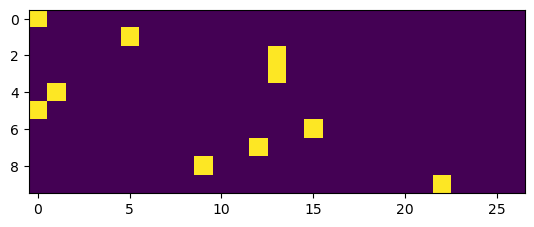

In [294]:
# represents .emma. as a one hot encoded tensor

plt.imshow(one_hot_x[:10])

In [308]:
W = torch.randn((27, 27))
log_counts = (one_hot_x @ W)
counts = log_counts.exp()
probs = counts / counts.sum(dim = 1, keepdim = True)

In [312]:
xs[:5]

tensor([ 0,  5, 13, 13,  1])

In [321]:
nlls = torch.zeros(5)
xs_ex, ys_ex = xs[:5], ys[:5]

for i in range(5):
    x = xs_ex[i].item()
    y = ys_ex[i].item()

    print('-----------')
    print(f'bigram example {i + 1}: {itos[x]}{itos[y]} (indexes {x}, {y})')
    print(f'input to the neural network: {x}')
    print(f'output probabilities: {probs[i]}')
    print(f'expected next label: {y}')
    p = probs[i, y]
    print(f'prob assigned by network to the correct char: {p}')
    logp = torch.log(p)
    nll = -logp
    nlls[i] = nll

print('-----------')
print(f'average log likelihood: {nlls.mean()}')


-----------
bigram example 1: .e (indexes 0, 5)
input to the neural network: 0
output probabilities: tensor([0.0184, 0.0300, 0.0395, 0.0332, 0.0350, 0.0195, 0.0145, 0.0094, 0.0559,
        0.0222, 0.0125, 0.0284, 0.0435, 0.1038, 0.0069, 0.0752, 0.0386, 0.0309,
        0.0092, 0.0496, 0.0783, 0.0300, 0.0269, 0.0381, 0.1110, 0.0255, 0.0141])
expected next label: 5
prob assigned by network to the correct char: 0.01946655660867691
-----------
bigram example 2: em (indexes 5, 13)
input to the neural network: 5
output probabilities: tensor([0.0091, 0.0524, 0.0272, 0.0424, 0.0170, 0.0773, 0.0549, 0.0499, 0.0649,
        0.0018, 0.0313, 0.0243, 0.1025, 0.0274, 0.0835, 0.0354, 0.0157, 0.0223,
        0.0048, 0.0375, 0.0558, 0.0475, 0.0198, 0.0094, 0.0531, 0.0261, 0.0064])
expected next label: 13
prob assigned by network to the correct char: 0.02737906016409397
-----------
bigram example 3: mm (indexes 13, 13)
input to the neural network: 13
output probabilities: tensor([0.0319, 0.0132, 0.0081, 

In [322]:
# use backpropagation to train the model

In [323]:
g = torch.Generator().manual_seed(214783647)
W = torch.randn((27, 27), requires_grad=True)

In [402]:
test_x = F.one_hot(xs, 27).float()
logits = test_x @ W
probabilities = logits.softmax(dim = 1)
loss = -probabilities[torch.arange(len(ys)), ys].log().mean()

In [403]:
# backward pass
W.grad = None
loss.backward()

In [404]:
W.data -= 0.1 * W.grad

In [405]:
print(loss.item())

3.7673299312591553


In [426]:
# full gradient descent

for _ in range(100):
    # forward pass
    test_x = F.one_hot(xs, 27).float()
    logits = test_x @ W
    probabilities = logits.softmax(dim = 1)
    loss = -probabilities[torch.arange(len(ys)), ys].log().mean() + 0.01 * (W ** 2).sum()

    # backward pass
    W.grad = None
    loss.backward()

    # gradient descent
    W.data -= 50 * W.grad

In [427]:
loss.item()

3.180938482284546

In [467]:
# finally, sample from the 'neural net' model
# g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ix = 0
  while True:
    
    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    
    ix = torch.multinomial(p, num_samples=1, replacement=True).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

hanhulzgdbqaopholozrve.
.
jgemkawpukcbidp.
fykunfeayn.
uqyphjje.


Now, let's try a MLP version based on maximizing the log-likelihood of the training data by adding a weight decay penalty (similar to ridge regression). Let's associate a feature vector with each word, allowing similar words to be placed together near the feature space, generalizing knowledge.

In [469]:
import torch
import torch.nn.functional as F

In [470]:
words = pd.read_table('names.txt', header=None, names=['name'])
words[:8]

name
0       emma
1     olivia
2        ava
3   isabella
4     sophia
5  charlotte
6        mia
7     amelia

In [474]:
chars = sorted(list(set(''.join(words['name']))))
char_to_idx = {c: i + 1 for i, c in enumerate(chars)}
char_to_idx['.'] = 0
idx_to_char = {i: c for c, i in char_to_idx.items()}


In [486]:
# build dataset

bsize = 3
X, Y = [], []
for w in words['name'][:5]:
    print(w)
    # use 3 previous characters to predict the next one (0 is the idx of ',', our starting token)
    context = [0] * bsize

    for ch in w + '.':
        idx = char_to_idx[ch]
        X.append(context)
        Y.append(idx)
        print(''.join([idx_to_char[i] for i in context]) + ' -> ' + idx_to_char[idx])

        # cropping and adding the next letter
        context = context[1:] + [idx]

X, Y = torch.tensor(X), torch.tensor(Y)

emma
... -> e
..e -> m
.em -> m
emm -> a
mma -> .
olivia
... -> o
..o -> l
.ol -> i
oli -> v
liv -> i
ivi -> a
via -> .
ava
... -> a
..a -> v
.av -> a
ava -> .
isabella
... -> i
..i -> s
.is -> a
isa -> b
sab -> e
abe -> l
bel -> l
ell -> a
lla -> .
sophia
... -> s
..s -> o
.so -> p
sop -> h
oph -> i
phi -> a
hia -> .


In [491]:
# X is the training set, Y are the training labels
# now, let's make C (taken from (https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf, page 1142)

C = torch.randn((27, 2))

In [517]:
C[5]

tensor([-2.1498,  0.8073])

In [518]:
F.one_hot(torch.tensor(5), num_classes = 27).float() @ C

tensor([-2.1498,  0.8073])

In [519]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [520]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [504]:
# now, we want to transform the embedding into a 32 x 6 tensor so we can make the actual dot product multiplication work

new_emb = torch.cat(torch.unbind(emb, dim = 1), dim = 1)

In [506]:
# the above is a way to do it, but there is another way of doing this
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [507]:
a.shape

torch.Size([18])

In [509]:
#  can we adjust a tensor by using .view(), which is significantly more efficent than our previous approaches
a.view(2, 9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [522]:
h = emb.view(-1, 6) @ W1 + b1
h

tensor([[-1.7426, -0.9071, -1.1058,  ..., -5.8078, -0.0881, -1.8792],
        [-3.8457, -1.3470,  0.5596,  ..., -7.3422,  3.3509, -1.2409],
        [ 1.0066, -3.2002, -2.0169,  ...,  6.1586,  3.0560,  3.9707],
        ...,
        [ 0.9016, -0.0787,  3.9455,  ...,  0.8623, -3.3302, -0.8064],
        [ 0.4898,  0.0902,  5.5546,  ..., -0.6055,  1.3935,  2.2850],
        [ 1.7167,  1.3386,  4.0531,  ...,  1.3500, -2.4218,  0.8590]])

In [523]:
h = torch.tanh(h)
h

tensor([[-0.9405, -0.7198, -0.8026,  ..., -1.0000, -0.0879, -0.9544],
        [-0.9991, -0.8733,  0.5077,  ..., -1.0000,  0.9975, -0.8457],
        [ 0.7644, -0.9967, -0.9652,  ...,  1.0000,  0.9956,  0.9993],
        ...,
        [ 0.7171, -0.0786,  0.9993,  ...,  0.6975, -0.9974, -0.6676],
        [ 0.4541,  0.0900,  1.0000,  ..., -0.5409,  0.8839,  0.9795],
        [ 0.9375,  0.8713,  0.9994,  ...,  0.8740, -0.9844,  0.6958]])

In [528]:
# second layer
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

logits = h @ W2 + b2
probabilities = logits.softmax(dim = 1)

# verify that softmaxing is working correctly
probabilities.sum(dim = 1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [530]:
# now, we want to index into Y

probabilities[0]

tensor([5.6309e-10, 3.0417e-12, 1.7575e-08, 1.4721e-14, 2.6321e-17, 1.1584e-03,
        4.1960e-07, 8.6031e-13, 1.0462e-09, 5.3933e-15, 1.4501e-09, 5.0982e-13,
        6.6490e-05, 1.9860e-09, 5.8478e-11, 1.9227e-08, 2.8311e-15, 2.6441e-12,
        7.6289e-09, 5.7829e-08, 7.0185e-12, 3.7566e-05, 2.4335e-13, 2.5350e-11,
        9.9873e-01, 1.2768e-17, 2.8236e-06])

In [531]:
torch.arange(32)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [532]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [534]:
loss = -probabilities[torch.arange(32), Y].log().mean()
loss

tensor(18.3326)

In [535]:
g = torch.Generator().manual_seed(214783647)
C = torch.randn((27, 2), generator = g)
W1 = torch.randn((6, 100), generator = g)
b1 = torch.randn(100, generator = g)
W2 = torch.randn((100, 27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

In [537]:
# total number of parameters

sum(p.nelement() for p in parameters)

3481

In [540]:
emb = C[X]
h = emb.view(-1, 6) @ W1 + b1
logits = torch.tanh(h) @ W2 + b2
# probabilities = logits.softmax(dim = 1)
# loss = -probabilities[torch.arange(32), Y].log().mean()
# loss

# F.cross_entropy does the same thing as the above
# It is faster and more stable (because it uses less memory because no initialization of variables is needed)
# It also allows a much easier backward pass for the gradient
# It is also inherently much more well behaved as well

loss = F.cross_entropy(logits, Y)

In [560]:
for p in parameters:
    p.requires_grad = True

for n in range(1000):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1) + b1 # first layer, results in a (32, 100) tensor
    logits = (h @ W2) + b2 # second layer, results in a (32, 27) tensor

    loss = F.cross_entropy(logits, Y)
    print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    for p in parameters:
        p.data -= 0.1 * p.grad

0.2744519114494324
0.274229496717453
0.2740115821361542
0.27379798889160156
0.2735885977745056
0.2733832001686096
0.2731817662715912
0.27298417687416077
0.27279025316238403
0.2725999653339386
0.2724132239818573
0.2722298502922058
0.27204978466033936
0.27187296748161316
0.2716992199420929
0.27152857184410095
0.271360844373703
0.27119603753089905
0.27103400230407715
0.27087464928627014
0.270717978477478
0.2705640196800232
0.2704124450683594
0.2702634632587433
0.27011677622795105
0.26997244358062744
0.26983046531677246
0.26969069242477417
0.2695530354976654
0.26941752433776855
0.26928409934043884
0.2691527009010315
0.26902326941490173
0.26889580488204956
0.26877015829086304
0.2686464488506317
0.26852449774742126
0.2684043049812317
0.2682858109474182
0.26816901564598083
0.26805388927459717
0.26794034242630005
0.26782843470573425
0.26771804690361023
0.26760920882225037
0.2675017714500427
0.26739585399627686
0.2672913074493408
0.267188161611557
0.267086386680603
0.2669859528541565
0.26688683

In [561]:
loss

tensor(0.2543, grad_fn=<NllLossBackward0>)

In [565]:
logits.max(1)

torch.return_types.max(
values=tensor([12.9081, 17.7354, 15.9714, 27.3106, 15.0750, 12.9081, 16.5910, 17.5826,
        20.4471, 18.8598, 19.0401, 22.1352, 12.9081, 20.0478, 15.4819, 16.9963,
        12.9081, 19.3994, 18.0273, 20.2868, 16.4240, 17.9176, 18.2761, 22.5072,
        21.1135, 12.9081, 19.0513, 17.1169, 17.2756, 18.3817, 19.0031, 20.1230],
       grad_fn=<MaxBackward0>),
indices=tensor([15, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0, 15, 22,  1,  0, 15, 19,
         1,  2,  5, 12, 12,  1,  0, 15, 15, 16,  8,  9,  1,  0]))

In [566]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [567]:
# for this example, we can see that the model is very good, because it only has 32 examples on 5 words
# however, we now have to adjust based on the entire dataset that we have

bsize = 3
X, Y = [], []
for w in words['name']:
    print(w)
    # use 3 previous characters to predict the next one (0 is the idx of ',', our starting token)
    context = [0] * bsize

    for ch in w + '.':
        idx = char_to_idx[ch]
        X.append(context)
        Y.append(idx)
        print(''.join([idx_to_char[i] for i in context]) + ' -> ' + idx_to_char[idx])

        # cropping and adding the next letter
        context = context[1:] + [idx]

X, Y = torch.tensor(X), torch.tensor(Y)

emma
... -> e
..e -> m
.em -> m
emm -> a
mma -> .
olivia
... -> o
..o -> l
.ol -> i
oli -> v
liv -> i
ivi -> a
via -> .
ava
... -> a
..a -> v
.av -> a
ava -> .
isabella
... -> i
..i -> s
.is -> a
isa -> b
sab -> e
abe -> l
bel -> l
ell -> a
lla -> .
sophia
... -> s
..s -> o
.so -> p
sop -> h
oph -> i
phi -> a
hia -> .
charlotte
... -> c
..c -> h
.ch -> a
cha -> r
har -> l
arl -> o
rlo -> t
lot -> t
ott -> e
tte -> .
mia
... -> m
..m -> i
.mi -> a
mia -> .
amelia
... -> a
..a -> m
.am -> e
ame -> l
mel -> i
eli -> a
lia -> .
harper
... -> h
..h -> a
.ha -> r
har -> p
arp -> e
rpe -> r
per -> .
evelyn
... -> e
..e -> v
.ev -> e
eve -> l
vel -> y
ely -> n
lyn -> .
abigail
... -> a
..a -> b
.ab -> i
abi -> g
big -> a
iga -> i
gai -> l
ail -> .
emily
... -> e
..e -> m
.em -> i
emi -> l
mil -> y
ily -> .
elizabeth
... -> e
..e -> l
.el -> i
eli -> z
liz -> a
iza -> b
zab -> e
abe -> t
bet -> h
eth -> .
mila
... -> m
..m -> i
.mi -> l
mil -> a
ila -> .
ella
... -> e
..e -> l
.el -> l
ell -> a

In [570]:
X.dtype, Y.dtype, X.shape, Y.shape

(torch.int64, torch.int64, torch.Size([228146, 3]), torch.Size([228146]))

In [571]:
C = torch.randn((27, 2))
emb = C[X]
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

h = (torch.tanh(emb.view(-1, 6) @ W1 + b1))

In [574]:
h

tensor([[ 0.9837, -0.1794, -0.9802,  ...,  0.0687, -0.9884, -0.9696],
        [ 0.9782, -0.5963, -0.9918,  ...,  0.7311, -0.9757, -0.9046],
        [ 0.9727, -1.0000, -0.9891,  ..., -0.8744,  0.9803, -0.8642],
        ...,
        [ 0.7894, -0.8076, -0.9862,  ...,  0.2207, -0.6170, -0.9585],
        [ 0.5046,  0.5652,  0.1731,  ..., -0.7129, -0.9956, -0.9694],
        [ 0.9424, -0.7750, -0.9900,  ...,  0.9233,  0.9038, -0.9854]])

In [575]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)

In [578]:
# now, let's train a neural network based on the entire dataset
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)


parameters = [C, W1, b1, W2, b2] # for a later part of the problem
for p in parameters:
    p.requires_grad = True


# full gradient descent is slow
for _ in range(100):
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)

    print(loss.item())

    for p in parameters:
        p.grad = None
    
    loss.backward()

    for p in parameters:
        p.data -= 0.1 * p.grad


17.490270614624023
14.98247241973877
13.35708999633789
12.313857078552246
11.562150001525879
10.922908782958984
10.308180809020996
9.74310302734375
9.370850563049316
9.118719100952148
8.685768127441406
8.383282661437988
8.10113525390625
7.859551429748535
7.58635139465332
7.3965020179748535
7.119186878204346
6.936651229858398
6.719380855560303
6.5802154541015625
6.365606784820557
6.251706600189209
6.055068016052246
5.968165874481201
5.780561923980713
5.713702201843262
5.534624099731445
5.480342864990234
5.313282489776611
5.266801357269287
5.114075660705566
5.071938514709473
4.934566020965576
4.8944010734558105
4.7724127769470215
4.733323097229004
4.625583171844482
4.587561130523682
4.492377281188965
4.45591926574707
4.371375560760498
4.336948394775391
4.261380672454834
4.229295253753662
4.161318778991699
4.131710052490234
4.070226192474365
4.043088912963867
3.987093210220337
3.962298631668091
3.9110970497131348
3.888500690460205
3.8413705825805664
3.8207449913024902
3.7771472930908203
3

In [719]:
# instead, another option we can do is do stochastic gradient descent

# use torch.randint to generate random indexes

W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)


parameters = [C, W1, b1, W2, b2] # for a later part of the problem
for p in parameters:
    p.requires_grad = True


# full gradient descent is slow
for _ in range(1000):
    ix = torch.randint(0, X.shape[0], (32,))
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    for p in parameters:
        p.grad = None
    
    loss.backward()

    for p in parameters:
        p.data -= 0.1 * p.grad

print(loss.item())

2.5188114643096924


In [720]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.5955, grad_fn=<NllLossBackward0>)

In [724]:
# to find a good learning rate, let's do some cross validation by trying different learnign rates

lrs = torch.linspace(0, 3, 1000)
les = 10 ** lrs

In [743]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)




parameters = [C, W1, b1, W2, b2] # for a later part of the problem
for p in parameters:
    p.requires_grad = True

learning_rates = []
losses = []

# full gradient descent is slow
for i in range(1000):
    ix = torch.randint(0, X.shape[0], (32,))
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    for p in parameters:
        p.grad = None
    
    loss.backward()

    lr = lrs[i]
    for p in parameters:
        p.data -= lr * p.grad
    
    learning_rates.append(lrs[i])
    losses.append(loss.item())

# print(loss.item())

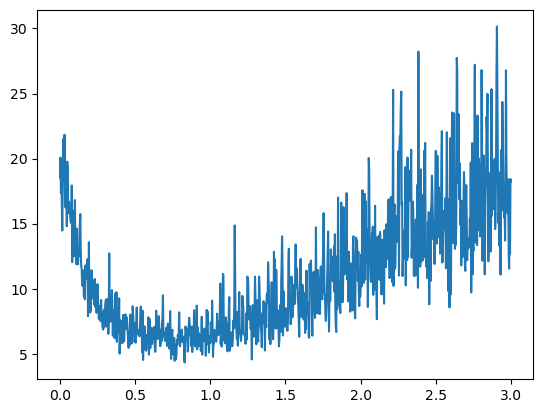

In [744]:
plt.plot(learning_rates, losses)

# It seems like around 0.5 - 1.5 is the best learning rate